## Setting up metadata for Dwingeloo LOFAR site (L311) & interaction with NRL

Author: Jelle Assink (jelle.assink@knmi.nl)

This code is distributed under the terms of the
GNU General Public License, Version 3
(https://www.gnu.org/licenses/gpl-3.0.en.html)

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [2]:
from obspy.core.inventory.util import Site
from obspy.core.inventory import Station
from obspy.clients.nrl import NRL
from obspy import UTCDateTime

In [3]:
from pysametadata.core.metadata import Metadata
from pysametadata.sensors.knmi import KNMImb
from pysametadata.dataloggers.guralp import CD24

In [4]:
import numpy as np

# Setting up the basis of an `Inventory`:

As an example, metadata will be prepared for the infrasound element located at ASTRON in Dwingeloo, i.e. NL.L311

In [5]:
NL_LOFAR = Metadata(code='NL', name='LOFAR', institute='KNMI',
                  description='Royal Netherlands Meteorological Institute')
NL_LOFAR.set_network(code=NL_LOFAR.code,
                   description='Netherlands Seismic and Acoustic Network',
                   starttime=UTCDateTime('1993-01-01T00:00:00'))
net = NL_LOFAR.network
NL_LOFAR.inventory.networks.append(NL_LOFAR.network)

In [6]:
site_info = Site('LOFAR Infrasound Array',
                 description='LOFAR Infrasound Array',
                 town='Dwingeloo', country='The Netherlands')

In [7]:
net.stations.append(Station('L311', 52.811785, 6.394668, 14.0, vault=1.0))

In [8]:
t0 = UTCDateTime('2020-225T17:30:00')

In [9]:
sta = net[0]
NL_LOFAR.set_station(sta, site_info, starttime=t0)
print(sta)

Station L311 (LOFAR Infrasound Array)
	Station Code: L311
	Channel Count: None/None (Selected/Total)
	2020-08-12T17:30:00.000000Z - 
	Access: open Alternate Code: LOFAR 
	Latitude: 52.81, Longitude: 6.39, Elevation: 14.0 m
	Available Channels:



# Setting up response information from home-made metadata classes

`NL.L311` consists of a KNMI microbarometer (KNMI-mb) with a [Guralp CD24-S3 datalogger](https://www.guralp.com/documents/html/MAN-C24-0001/). The sensitivity and response information of these instruments are provided by the `KNMImb` and `CD24` classes that are part of `pysametadata`.

The response of the KNMI microbarometer can be described by its poles and zeros, which have been derived from the properties of the instrument. In particular, the low-frequency cut-off is determined by the properties of the capillary and the backing volume. Its high-frequency cut-off is here determined by the wind noise reduction system (*wnrs*) that effectively acts as a low-pass filter. Its corner frequency is dependent on the length of the *wnrs*. More information can be found in [Mentink and Evers (2011)](https://doi.org/10.1121/1.3596718) as well as the [PhD thesis (2008)](http://resolver.tudelft.nl/uuid:4de38d6f-8f68-4706-bf34-4003d3dff0ce) by Läslo Evers. 

The sensitivity of the KNMI-mb has emperically been determined at approximately 17 mV/Pa. The Guralp CD24 datalogger is a 24-bit datalogger that is configured with a sample rate of 100 Hz and has a calibrated sensitivity of approximately 0.96e-6 V/Count (actual value depends on the serial number of the unit). The calibration values of the units that are in use by KNMI are part of `pysametadata`.

Putting all this information together we get the following design:

In [10]:
channel = NL_LOFAR.set_channel('HDF', sta,
                             sample_rate=100.0, starttime=t0)
my_sensor = KNMImb(channel, model='1000s', wnrs_diameter=10.0)
my_sensor.set_response(stage=1)
my_logger = CD24(channel, serial_number='C556', sens_freq=my_sensor.sens_freq)
my_logger.set_response(stage=2)
NL_LOFAR.calculate_sensitivity(channel)
sta.channels.append(channel)

The constructed response can be reviewed and be plotted:

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 18459.5 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.04275e+06


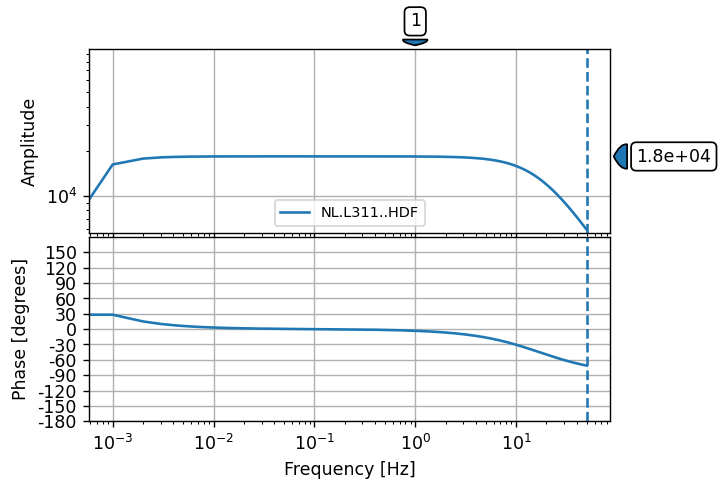

In [11]:
print(channel.response)
fig=channel.plot(1e-3, unwrap_phase=True, label=channel.seed_id, plot_degrees=True)
ax_list=fig.axes

# Comparison with NRL Guralp CD24 response

Now, a new channel response is defined. The KNMI-mb response and the common attributes of the CD24 datalogger will be kept, but instead of using the 'home-made' CD24 response (which is a simple flat line with a gain determined by the serial number), now we are going to use the official response file that is provided by the Nominal Response Library (NRL). This response file also includes all the finite impulse response (FIR) digital filters that are part of the dataloggers.

First set up a new `Channel`, again with the `KNMImb` and `Obsidian` objects. Note that we do not apply the `set_response()` methods yet.

In [12]:
channel_nrl = NL_LOFAR.set_channel('HDF', sta, location='00',
                             sample_rate=100.0, starttime=t0)
my_sensor = KNMImb(channel_nrl, model='1000s', wnrs_diameter=10.0)
my_logger = CD24(channel_nrl, serial_number='C556', sens_freq=my_sensor.sens_freq)

The next step is to initialise ObsPy's built-in NRL client to connect to the online database.

In [13]:
nrl = NRL()

As an example, we take the response model for a Guralp CD24 datalogger configured with tap 41. The datalogger samples at 100 Hz.

In [14]:
print(nrl.dataloggers['Guralp']['CMG-CD24 (standalone)']['41-50']['41']['100'])

('CD24, gain 1, 100 sps, tap id 41 (1000 200 100 50 25 Hz)', 'http://ds.iris.edu/NRL/dataloggers/guralp/CMG_CD24/RESP.XX.G3513..HHZ.CMG_CD24.1.1000_200_100.100')


Now download the response information, to be attached to the `Channel` object.

In [15]:
# Obtain response information for Guralp digitiser
guralp_keys = ['Guralp','CMG-CD24 (standalone)','41-50','41','100']
guralp_response = nrl.get_datalogger_response(guralp_keys)
print(guralp_response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 322581 defined at 0.050 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 322581
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Note that the gain in the second stage should come from the calibation datasheet. This information is part of the `CD24` class and stored in `my_logger.gain`.

In [16]:
guralp_response.response_stages[2].stage_gain = my_logger.gain
print(guralp_response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 322581 defined at 0.050 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.04275e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Now the first stage should be replaced with the response information of `my_sensor`:

In [17]:
channel_nrl.response = guralp_response
channel_nrl.response.response_stages.pop(0)
my_sensor.set_response(stage=1)

And voilà:

In [18]:
print(channel_nrl.response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 322581 defined at 0.050 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.04275e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Last thing to do is to recalculate the overall gain and frequency settings, which are set by the sensor. Then we can add the `Channel` object to the `Station` object.

In [19]:
NL_LOFAR.calculate_sensitivity(channel_nrl)
sta.channels.append(channel_nrl)

Now plot the result.

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 18459.5 defined at 1.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.04275e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


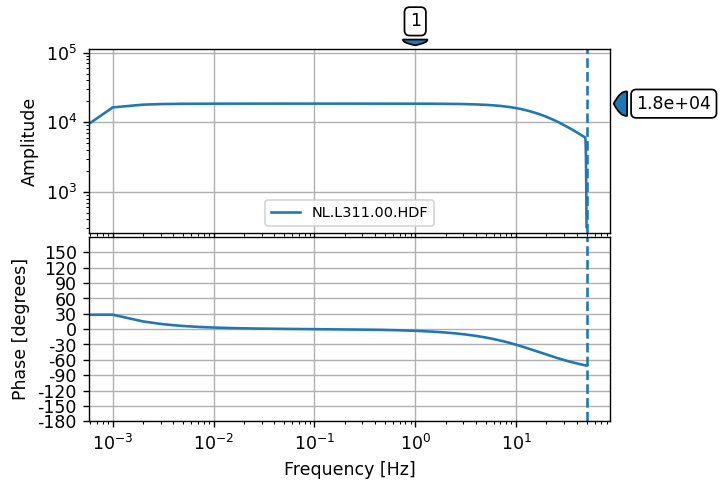

In [20]:
print(channel_nrl.response)
fig=channel_nrl.plot(1e-3, unwrap_phase=True, label=channel_nrl.seed_id, plot_degrees=True)
ax_list=fig.axes

## Comparing response models

In [21]:
def get_response_function(channel,min_freq):
    sampling_rate = channel.sample_rate
    nyquist = channel.sample_rate / 2.0
    nfft = int(sampling_rate / min_freq)
    t_samp = 1./sampling_rate
    cpx_response, freq = channel.response.get_evalresp_response(t_samp=t_samp, nfft=nfft, output='VEL')
    return(cpx_response,freq)

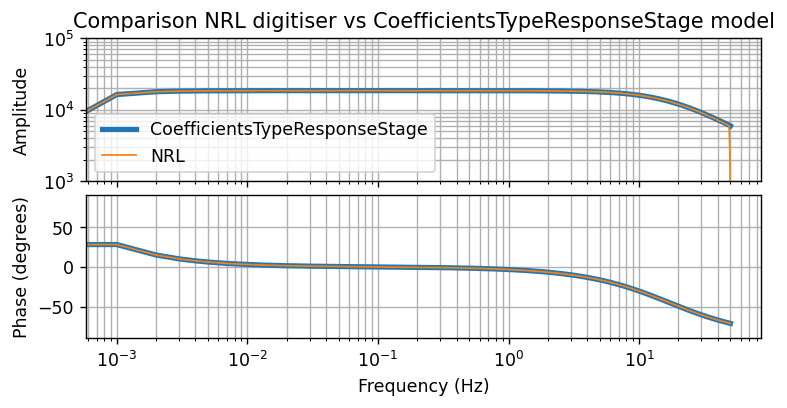

In [22]:
(H,f) = get_response_function(channel,1e-3)
(H_nrl,f) = get_response_function(channel_nrl,1e-3)

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 3 ))
ax[0].set_title('Comparison NRL digitiser vs CoefficientsTypeResponseStage model')
ax[0].loglog(f,abs(H),linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[0].loglog(f,abs(H_nrl),linewidth=1.0,label='NRL')
ax[0].set_ylim([1e3,1e5])
ax[0].grid(which='both')
ax[0].legend()
ax[0].set(ylabel='Amplitude')


phase = np.angle(H, deg=True)
phase_nrl = np.angle(H, deg=True)
ax[1].semilogx(f,phase,linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[1].semilogx(f,phase_nrl,linewidth=1.0,label='NRL')
ax[1].set_ylim([-90,90])
ax[1].grid(which='both')
ax[1].set(xlabel='Frequency (Hz)',ylabel='Phase (degrees)')

fig = plt.gcf()
# make room for title and colorbars
fig.subplots_adjust(bottom=0.05, top=0.85, left=0.1, right=1,
                    hspace=0.1)

fig.align_ylabels(ax)

plt.show()

As you can see both models are quite similar, except for the high-pass filter above 40 Hz, which is not part of the `CoefficientsTypeResponseStage` model.

Now let's review the overall inventory:

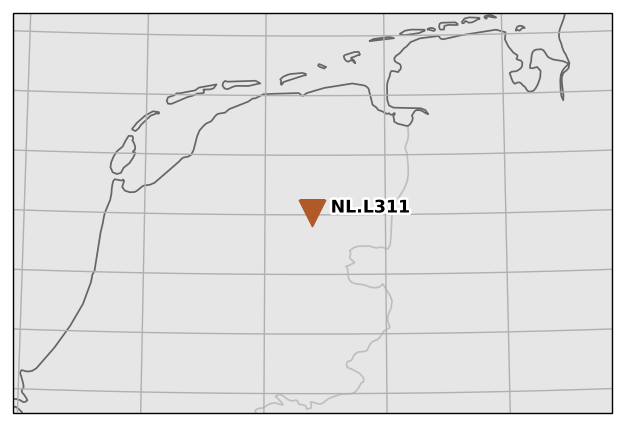

In [23]:
fig=NL_LOFAR.inventory.plot(projection='local',resolution='f')

In [24]:
print(NL_LOFAR.inventory)

Inventory created at 2020-09-17T10:56:43.445171Z
	Created by: ObsPy 1.2.1
		    https://www.obspy.org
	Sending institution: Royal Netherlands Meteorological Institute (KNMI)
	Contains:
		Networks (1):
			NL
		Stations (1):
			NL.L311 (LOFAR Infrasound Array)
		Channels (2):
			NL.L311..HDF, NL.L311.00.HDF


Of course the inventory can be written to disk:


Station L311 (LOFAR Infrasound Array)
	Station Code: L311
	Channel Count: None/None (Selected/Total)
	2020-08-12T17:30:00.000000Z - 
	Access: open Alternate Code: LOFAR 
	Latitude: 52.81, Longitude: 6.39, Elevation: 14.0 m
	Available Channels:
		L311..HDF, L311.00.HDF
Inventory created at 2020-09-17T10:56:43.445171Z
	Created by: ObsPy 1.2.1
		    https://www.obspy.org
	Sending institution: Royal Netherlands Meteorological Institute (KNMI)
	Contains:
		Networks (1):
			NL
		Stations (1):
			NL.L311 (LOFAR Infrasound Array)
		Channels (2):
			NL.L311..HDF, NL.L311.00.HDF
--------------------------------------------------------------------------------
Channel 'HDF', Location '' (Microbarometric pressure)
	Time range: 2020-08-12T17:30:00.000000Z - --
	Latitude: 52.81, Longitude: 6.39, Elevation: 14.0 m, Local Depth: 1.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): KNMI-mb 1000s (KNMI 1000s different

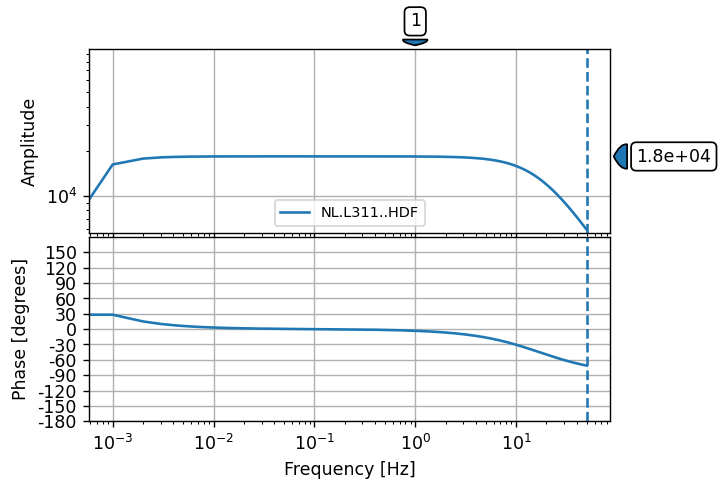

--------------------------------------------------------------------------------
Channel 'HDF', Location '00' (Microbarometric pressure)
	Time range: 2020-08-12T17:30:00.000000Z - --
	Latitude: 52.81, Longitude: 6.39, Elevation: 14.0 m, Local Depth: 1.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): KNMI-mb 1000s (KNMI 1000s differential microbarometer)
	Response information available
Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 18459.5 defined at 1.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.0177027
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.04275e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		S

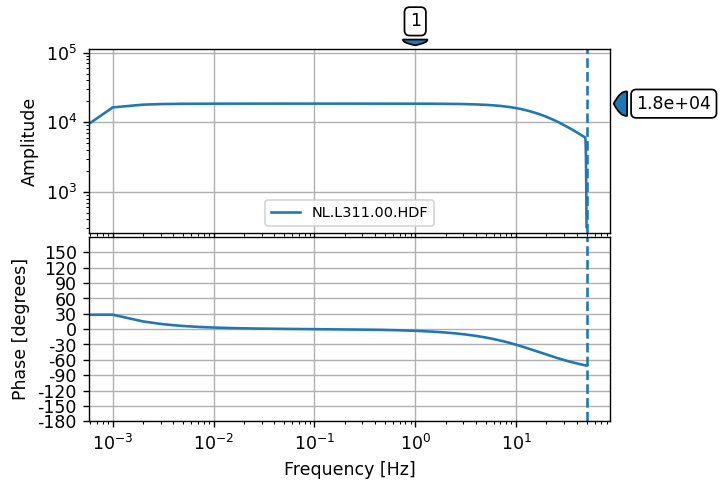

Writing out [ NL.LOFAR/NL.L311.xml ] ...



In [25]:
NL_LOFAR.write(plot_response=True, write_group=False)